In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
 import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import entropy

In [46]:
path="/content/drive/MyDrive/Research/AAAI/dataset1/second_layer_with_entropy/"

In [47]:
data = np.load(path+"mosaic_dataset_1.npy",allow_pickle=True)

In [48]:
class MosaicDataset1(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label,fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] , self.fore_idx[idx]

In [49]:
mosaic_list_of_images = data[0]["mosaic_list"]
mosaic_label = data[0]["mosaic_label"]
fore_idx = data[0]["fore_idx"]

In [50]:
batch = 250
msd = MosaicDataset1(mosaic_list_of_images, mosaic_label, fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

**Focus Net**

In [51]:
class Focus_deep(nn.Module):
    '''
       deep focus network averaged at zeroth layer
       input : elemental data
    '''
    def __init__(self,inputs,output,K,d):
        super(Focus_deep,self).__init__()
        self.inputs = inputs
        self.output = output
        self.K = K
        self.d  = d
        self.linear1 = nn.Linear(self.inputs,50)  #,self.output)
        self.linear2 = nn.Linear(50,50)
        self.linear3 = nn.Linear(50,self.output) 

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.zeros_(self.linear2.bias)
        
    def forward(self,z):
        batch = z.shape[0]
        x = torch.zeros([batch,self.K],dtype=torch.float64)
        y = torch.zeros([batch,50], dtype=torch.float64)   # number of features of output
        features = torch.zeros([batch,self.K,50],dtype=torch.float64)
        x,y = x.to("cuda"),y.to("cuda")
        features = features.to("cuda")
        for i in range(self.K):
            alp,ftrs = self.helper(z[:,i] )  # self.d*i:self.d*i+self.d
            x[:,i] = alp[:,0]
            features[:,i]  = ftrs 
        log_x = F.log_softmax(x,dim=1)
        x = F.softmax(x,dim=1)   # alphas
        for i in range(self.K):
            x1 = x[:,i]          
            y = y+torch.mul(x1[:,None],features[:,i])  # self.d*i:self.d*i+self.d
        return y , x , log_x
    def helper(self,x):
      x = self.linear1(x)
      x = F.relu(x) 
      x = self.linear2(x)
      x1 = F.tanh(x)
      x = F.relu(x)
      x = self.linear3(x)
      #print(x1.shape)
      return x,x1

**Classification Net**

In [52]:
class Classification_deep(nn.Module):
    '''
       input : elemental data
       deep classification module data averaged at zeroth layer
    '''
    def __init__(self,inputs,output):
        super(Classification_deep,self).__init__()
        self.inputs = inputs
        self.output = output
        self.linear1 = nn.Linear(self.inputs,50)
        #self.linear2 = nn.Linear(6,12)
        self.linear2 = nn.Linear(50,self.output)

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)

    def forward(self,x):
      x = F.relu(self.linear1(x))
      #x = F.relu(self.linear2(x))
      x = self.linear2(x)
      return x    

In [53]:
criterion = nn.CrossEntropyLoss()
def my_cross_entropy(x, y,alpha,log_alpha,k):
    # log_prob = -1.0 * F.log_softmax(x, 1)
    # loss = log_prob.gather(1, y.unsqueeze(1))
    # loss = loss.mean()
    loss = criterion(x,y)
    
    #alpha = torch.clamp(alpha,min=1e-10)     
    
    b = -1.0* alpha * log_alpha
    b =  torch.mean(torch.sum(b,dim=1))
    closs = loss
    entropy = b 
    loss = (1-k)*loss + ((k)*b)
    return loss,closs,entropy

In [54]:
def calculate_attn_loss(dataloader,what,where,criter,k):
  what.eval()
  where.eval()
  r_loss = 0
  cc_loss = 0
  cc_entropy = 0
  alphas = []
  lbls = []
  pred = []
  fidices = []
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels,fidx = data
      lbls.append(labels)
      fidices.append(fidx)
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      avg,alpha,log_alpha = where(inputs)
      outputs = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      pred.append(predicted.cpu().numpy())
      alphas.append(alpha.cpu().numpy())

      #ent = np.sum(entropy(alpha.cpu().detach().numpy(), base=2, axis=1))/batch
      # mx,_ = torch.max(alpha,1)
      # entropy = np.mean(-np.log2(mx.cpu().detach().numpy()))
      # print("entropy of batch", entropy)

      #loss = (1-k)*criter(outputs, labels) + k*ent
      loss,closs,entropy = my_cross_entropy(outputs,labels,alpha,log_alpha,k)
      r_loss += loss.item()
      cc_loss += closs.item()
      cc_entropy += entropy.item()

  alphas = np.concatenate(alphas,axis=0)
  pred = np.concatenate(pred,axis=0)
  lbls = np.concatenate(lbls,axis=0)
  fidices = np.concatenate(fidices,axis=0)
  #print(alphas.shape,pred.shape,lbls.shape,fidices.shape) 
  analysis = analyse_data(alphas,lbls,pred,fidices)
  return r_loss/i,cc_loss/i,cc_entropy/i,analysis

In [55]:
def analyse_data(alphas,lbls,predicted,f_idx):
    '''
       analysis data is created here
    '''
    batch = len(predicted)
    amth,alth,ftpt,ffpt,ftpf,ffpf = 0,0,0,0,0,0
    for j in range (batch):
      focus = np.argmax(alphas[j])
      if(alphas[j][focus] >= 0.5):
        amth +=1
      else:
        alth +=1
      if(focus == f_idx[j] and predicted[j] == lbls[j]):
        ftpt += 1
      elif(focus != f_idx[j] and predicted[j] == lbls[j]):
        ffpt +=1
      elif(focus == f_idx[j] and predicted[j] != lbls[j]):
        ftpf +=1
      elif(focus != f_idx[j] and predicted[j] != lbls[j]):
        ffpf +=1
    #print(sum(predicted==lbls),ftpt+ffpt)
    return [ftpt,ffpt,ftpf,ffpf,amth,alth]

In [56]:
number_runs = 20
full_analysis =[]
FTPT_analysis = pd.DataFrame(columns = ["FTPT","FFPT", "FTPF","FFPF"])
k = 0.001
for n in range(number_runs):
  print("--"*40)
  
  # instantiate focus and classification Model
  torch.manual_seed(n)
  where = Focus_deep(2,1,9,2).double()
  torch.manual_seed(n)
  what = Classification_deep(50,3).double()
  where = where.to("cuda")
  what = what.to("cuda")

  # instantiate optimizer
  optimizer_where = optim.Adam(where.parameters(),lr =0.001)
  optimizer_what = optim.Adam(what.parameters(), lr=0.001)
  #criterion = nn.CrossEntropyLoss()
  acti = []
  analysis_data = []
  loss_curi = []
  epochs = 1500


  # calculate zeroth epoch loss and FTPT values
  running_loss ,_,_,anlys_data= calculate_attn_loss(train_loader,what,where,criterion,k)
  loss_curi.append(running_loss)
  analysis_data.append(anlys_data)

  print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 

  # training starts 
  for epoch in range(epochs): # loop over the dataset multiple times
    ep_lossi = []
    running_loss = 0.0
    what.train()
    where.train()
    for i, data in enumerate(train_loader, 0):
      # get the inputs
      inputs, labels,_ = data
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"),labels.to("cuda")

      # zero the parameter gradients
      optimizer_where.zero_grad()
      optimizer_what.zero_grad()
      
      # forward + backward + optimize
      avg, alpha,log_alpha = where(inputs)
      outputs = what(avg)

      my_loss,_,_ = my_cross_entropy(outputs,labels,alpha,log_alpha,k)

      # print statistics
      running_loss += my_loss.item()
      my_loss.backward()
      optimizer_where.step()
      optimizer_what.step()
    #break
    running_loss,ccloss,ccentropy,anls_data = calculate_attn_loss(train_loader,what,where,criterion,k)
    analysis_data.append(anls_data)
    print('epoch: [%d] loss: %.3f celoss: %.3f entropy: %.3f' %(epoch + 1,running_loss,ccloss,ccentropy)) 
    loss_curi.append(running_loss)   #loss per epoch
    if running_loss<=0.001:
      break
  print('Finished Training run ' +str(n))
  #break
  analysis_data = np.array(analysis_data)
  FTPT_analysis.loc[n] = analysis_data[-1,:4]/30
  full_analysis.append((epoch, analysis_data))
  correct = 0
  total = 0
  with torch.no_grad():
    for data in train_loader:
      images, labels,_ = data
      images = images.double()
      images, labels = images.to("cuda"), labels.to("cuda")
      avg, alpha,log_alpha = where(images)
      outputs  = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 3000 train images: %d %%' % (  100 * correct / total))
    

--------------------------------------------------------------------------------
epoch: [0 ] loss: 1.210


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Streaming output truncated to the last 5000 lines.
epoch: [272] loss: 0.001 celoss: 0.000 entropy: 0.904
epoch: [273] loss: 0.001 celoss: 0.000 entropy: 0.903
epoch: [274] loss: 0.001 celoss: 0.000 entropy: 0.900
epoch: [275] loss: 0.001 celoss: 0.000 entropy: 0.896
epoch: [276] loss: 0.001 celoss: 0.000 entropy: 0.894
epoch: [277] loss: 0.001 celoss: 0.000 entropy: 0.894
epoch: [278] loss: 0.001 celoss: 0.000 entropy: 0.891
epoch: [279] loss: 0.001 celoss: 0.000 entropy: 0.888
epoch: [280] loss: 0.001 celoss: 0.000 entropy: 0.886
epoch: [281] loss: 0.001 celoss: 0.000 entropy: 0.886
epoch: [282] loss: 0.001 celoss: 0.000 entropy: 0.882
epoch: [283] loss: 0.001 celoss: 0.000 entropy: 0.881
epoch: [284] loss: 0.001 celoss: 0.000 entropy: 0.879
epoch: [285] loss: 0.001 celoss: 0.000 entropy: 0.877
epoch: [286] loss: 0.001 celoss: 0.000 entropy: 0.875
epoch: [287] loss: 0.001 celoss: 0.000 entropy: 0.873
epoch: [288] loss: 0.001 celoss: 0.000 entropy: 0.871
epoch: [289] loss: 0.001 celoss

In [57]:
a,b= full_analysis[0]
print(a)

294


In [58]:
np.mean(np.array(FTPT_analysis),axis=0) #array([87.85333333,  5.92      ,  0.        ,  6.22666667])

array([78.00166667, 21.99833333,  0.        ,  0.        ])

In [59]:
FTPT_analysis

,FTPT,FFPT,FTPF,FFPF
0,90.133333,9.866667,0.0,0.0
1,71.066667,28.933333,0.0,0.0
2,86.166667,13.833333,0.0,0.0
3,71.066667,28.933333,0.0,0.0
4,89.800000,10.200000,0.0,0.0
5,79.500000,20.500000,0.0,0.0
6,71.100000,28.900000,0.0,0.0
7,74.066667,25.933333,0.0,0.0
8,71.066667,28.933333,0.0,0.0
9,99.300000,0.700000,0.0,0.0


In [60]:
FTPT_analysis[FTPT_analysis['FTPT'] > 95]

,FTPT,FFPT,FTPF,FFPF
9,99.300000,0.700000,0.0,0.0
14,99.166667,0.833333,0.0,0.0


In [61]:
np.mean(np.array(FTPT_analysis[FTPT_analysis['FTPT'] > 95]),axis=0)

array([99.23333333,  0.76666667,  0.        ,  0.        ])

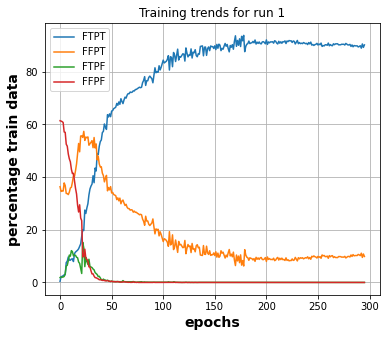

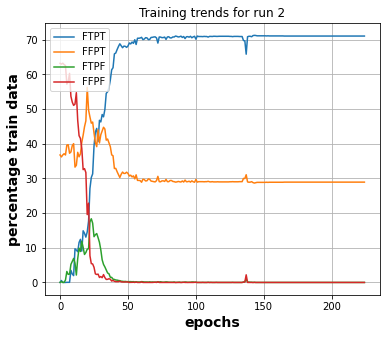

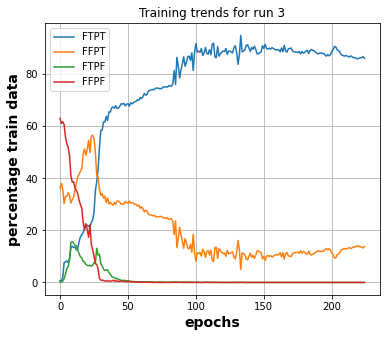

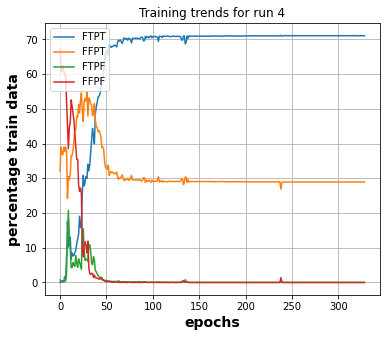

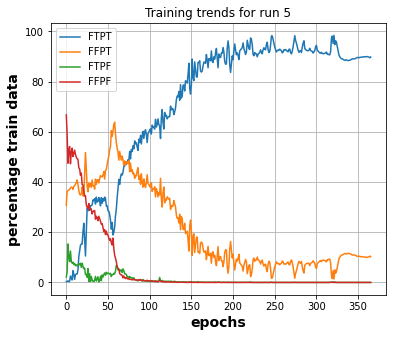

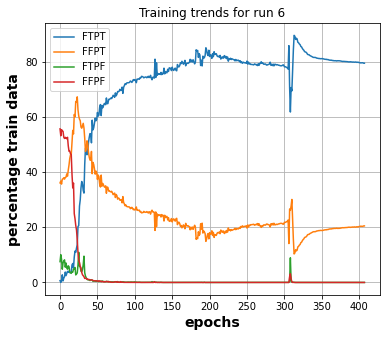

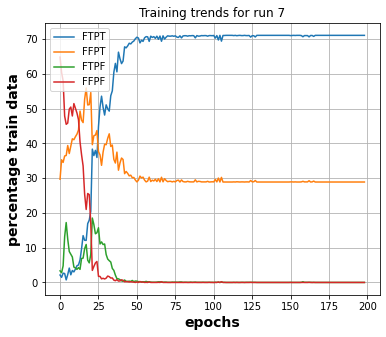

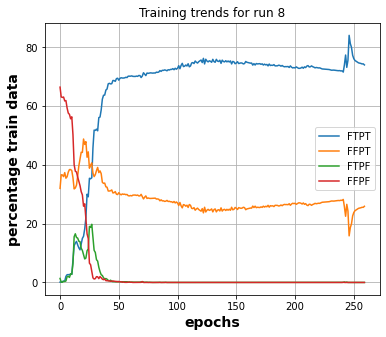

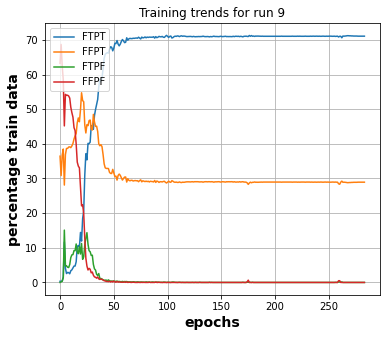

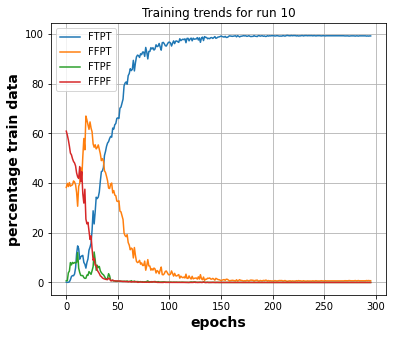

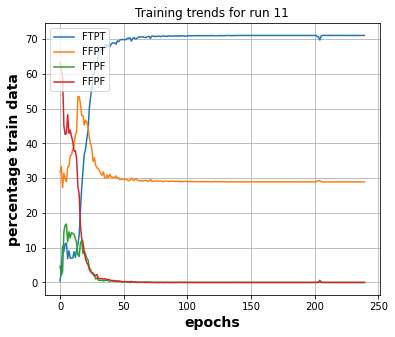

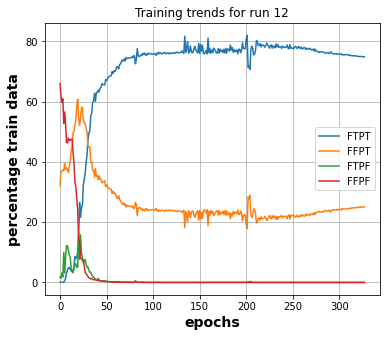

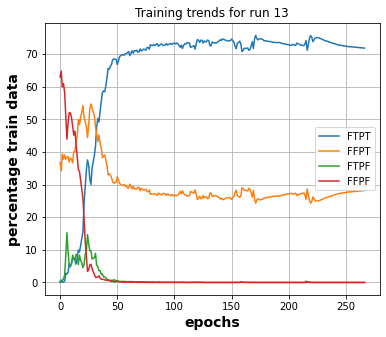

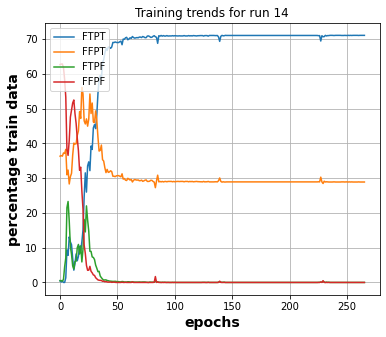

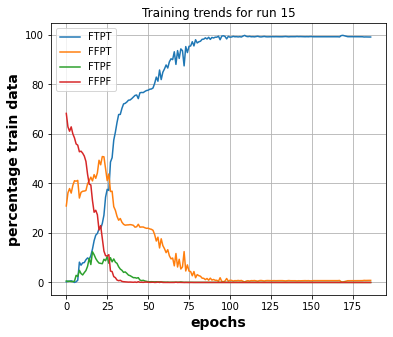

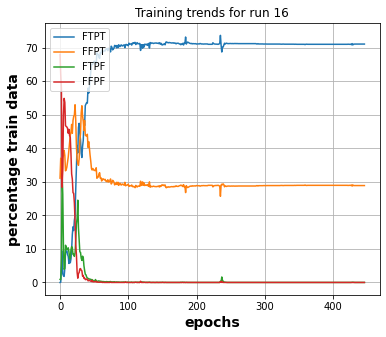

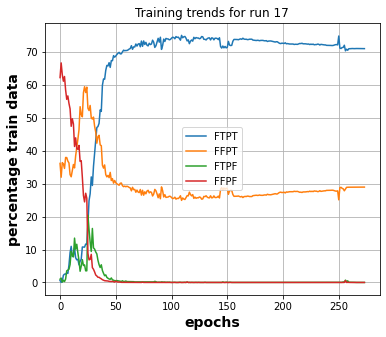

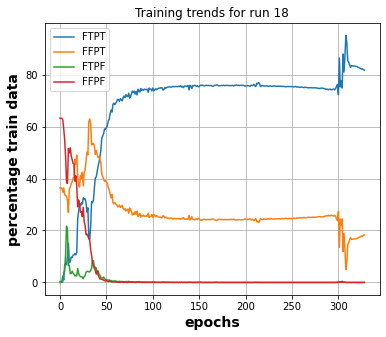

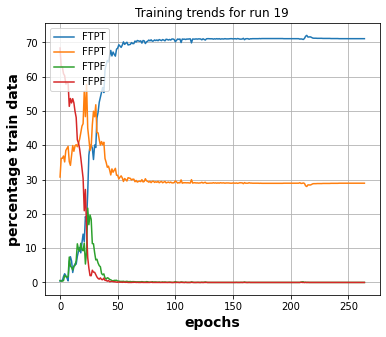

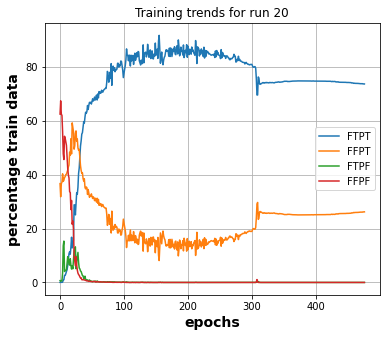

In [62]:
cnt=1
for epoch, analysis_data in full_analysis:
  analysis_data = np.array(analysis_data)
  # print("="*20+"run ",cnt,"="*20)
  
  plt.figure(figsize=(6,5))
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,0]/30,label="FTPT")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,1]/30,label="FFPT")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,2]/30,label="FTPF")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,3]/30,label="FFPF")

  plt.title("Training trends for run "+str(cnt))
  plt.grid()
  # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.legend()
  plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
  plt.ylabel("percentage train data", fontsize=14, fontweight = 'bold')
  plt.savefig(path + "run"+str(cnt)+".png",bbox_inches="tight")
  plt.savefig(path + "run"+str(cnt)+".pdf",bbox_inches="tight")
  cnt+=1

In [63]:
FTPT_analysis.to_csv(path+"synthetic_zeroth.csv",index=False)